In [15]:
import torch
import torch.nn as nn
import load_data
import torchviz
from torch.utils.tensorboard import SummaryWriter
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [2]:
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

In [3]:
train_dataloader, test_dataloader = load_data.buildLoaders(
    annotations_file=r"C:\Users\Emily\Documents\Bachelor_Artefakte\image_data.csv",
    img_dir=r"C:\Users\Emily\Documents\Bachelor_Drohnen_Bilder\PNG", size=1000,
    color="rgb", batch_size=1)

In [4]:
images, labels = next(iter(test_dataloader))

In [6]:
img_grid = torchvision.utils.make_grid(images)

In [8]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

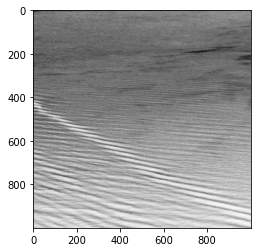

In [9]:
matplotlib_imshow(img_grid, one_channel=True)

In [10]:
writer.add_image('four_fashion_mnist_images', img_grid)

In [12]:
class NeuralNetwork(nn.Module):
    """
    Neurale Network Klasse entsprechend Pytorch. Erbt von nn.module
    """
    def __init__(self):
        """
        Init methode für die klasse. Hier werden verschiedene Layer für das Netzwerk gebaut
        """
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1000 * 1000 * 3, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100, 10, bias=True),
            nn.ReLU(),
            nn.Linear(10, 4, bias=True)
        )
        self.conv = nn.Sequential(  # Das müsste in etwa unsere idee mit dem 5 kernel abbilden?
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5),
            nn.Flatten()
        )
        self.conv2 = nn.Sequential(
            nn.Linear(396010, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100, 10, bias=True),
            nn.ReLU(),
            nn.Linear(10, 4, bias=True)
        )

    def forward(self, x):
        """
        Forward methode entsprechend pytorch. Hier entsteht das eigentliche Model
        :param x:
        :return:
        """
        # logits = self.layers(x)
        x = self.conv(x)
        # print(x)
        logits = self.conv2(x)
        return logits

In [13]:
model = NeuralNetwork()
model.load_state_dict(torch.load(r"C:\Users\Emily\Documents\Bachelor_Artefakte\modelle\model.pth",map_location=torch.device('cpu')))
model.eval()

NeuralNetwork(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3000000, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=4, bias=True)
  )
  (conv): Sequential(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (conv2): Sequential(
    (0): Linear(in_features=396010, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=10, bias

In [14]:
writer.add_graph(model, images)
writer.close()

c:\users\emily\documents\notebooks\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [16]:
class_probs = []
class_label = []
class_label = []
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        output = model(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)
test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

In [17]:
classes = ("Himmel","Strand","Wasser","Nix")

In [18]:
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)

In [19]:
model

NeuralNetwork(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3000000, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=4, bias=True)
  )
  (conv): Sequential(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (conv2): Sequential(
    (0): Linear(in_features=396010, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=10, bias